# デュアル構造を持つネットワークの検索用ノートブック(2019/11/26作成)

- リファクタリングを兼ねてもう一度綺麗に実装してみる

## 初期設定とライブラリのimport

In [38]:
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt 
from tqdm import tqdm
import os

In [39]:
BASE_PATH = './dataset/T_Shirt_all/'
model = 'improvedTripletLoss'
model = 'TripletLoss'

## エラー対応
- ~~**RTX系のGPU**で回すとUnknownErrorを吐くため以下コードにより回避~~
- なぜかこちらのコードがエラーを吐くようになった(GPUマシンのアップデート後)
- GPU番号を指定していないことが原因らしい

In [40]:
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# tf.keras.backend.set_session(tf.Session(config=config))

- GPUを指定する

In [41]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        visible_device_list="0", # specify GPU number
        allow_growth=True
    )
)
set_session(tf.Session(config=config))

## モデルの読み込み

In [42]:
from keras.models import load_model

In [43]:
vec_length = 300
model_epoch = 99
ALPHA = 0.1
BETA = 0.05 #improved triplet lossの場合

In [44]:
# model_dir = "./model/T_Shirt/improved_tripletloss/a{}b{}".format(ALPHA,BETA)
model_dir = "./model/T_Shirt/improvedEditFiler/a{}b{}".format(ALPHA,BETA)

In [45]:
con_embNet = load_model(model_dir+'/{}/con_e{}.h5'.format(vec_length,model_epoch), compile=False)
shop_embNet = load_model(model_dir+'/{}/shop_e{}.h5'.format(vec_length,model_epoch), compile=False)

In [46]:
# con_embNet = load_model('./model/T_Shirt/tripletloss/a0.1/512/con_e99.h5', compile=False)
# shop_embNet = load_model('./model/T_Shirt/tripletloss/a0.1/512/shop_e99.h5', compile=False)

## Testデータの読み込み
- 学習前にtrain/test分割してpickle保存したファイルからtestに用いる商品idをロードする
- 一つの商品idに対して一つの[Street画像,Shop画像]ペアとする。詳しくは`./datagen.py`参照

In [47]:
f = open("./pickle/T_Shirt/test_ids.pickle","rb")
test_ids = pickle.load(f) #test用の商品id

- 自作モジュールのインポート

In [48]:
from modules import datagen

In [49]:
test_pairs = datagen.get_test_pairs(test_ids,BASE_PATH,seed_num=0)

100%|██████████| 2032/2032 [00:00<00:00, 4401.63it/s]


- 中身は`[商品id,[Street画像のパス,Shop画像のパス]]`

In [50]:
test_pairs[0]

[10696,
 ['./dataset/T_Shirt_all/id_00010696/comsumer_01.jpg',
  './dataset/T_Shirt_all/id_00010696/shop_01.jpg']]

- 作成したtest_pairsをpickleで保存する

In [51]:
f = open('./pickle/T_Shirt/test_pairs.pickle', 'wb')
pickle.dump(test_pairs, f)

## 検索対象の画像群(gallery)の作成

- galleryリストに対して、test_pairsから[商品id, Shop画像パス]のリスト作成してappendする

In [52]:
gallery = []
for tp in test_pairs:
    gallery.append([tp[0],tp[1][1]])

In [53]:
print(gallery[0])
print('gallery length = {}'.format(len(gallery)))

[10696, './dataset/T_Shirt_all/id_00010696/shop_01.jpg']
gallery length = 2032


## galleryを特徴空間ベクトルに埋め込む

- 埋め込み次元はvec_lengthとして定義済み
- 最初に次元数分のnumpy配列を用意しておき、書き換える。
- ans_idsは正解となる商品idのリスト(test_pairsをforで回してtp[0]のリストを作るのと同義)

In [54]:
emb_vecs = np.zeros((len(gallery),vec_length))
ans_ids = np.zeros(len(gallery))
print(emb_vecs.shape)
print(ans_ids.shape)

(2032, 300)
(2032,)


- shop_embNet.predict()で推論を行う。デュアル構造のため、入力として同じimgを二つ与える
- 入力時の形を合わせるためexpand_dimsの処理が必要(試行錯誤の結果なので詳細は忘れた)

In [55]:
for i,g in enumerate(tqdm(gallery)):
    img =np.array(Image.open(g[1]).resize((128,128)).convert('RGB'))/255.
    ans_ids[i] = g[0]
    emb_vecs[i] = shop_embNet.predict([np.expand_dims(img,axis=0),np.expand_dims(img,axis=0)])[0] # need [0] because of expanding dimension -> [[]]

100%|██████████| 2032/2032 [00:14<00:00, 139.83it/s]


- **重要!!** 後に結果を解釈するために埋め込んだベクトルをpickleに保存

In [56]:
f = open(model_dir+'/{}/gallery{}.txt'.format(vec_length,model_epoch),'wb')
pickle.dump(emb_vecs,f)

In [57]:
# f = open('./model/T_Shirt/tripletloss/a{}/{}/gallery{}.txt'.format(ALPHA,vec_length,model_epoch),'wb')
# pickle.dump(emb_vecs,f)

- ユークリッド距離計算用関数

In [58]:
def euclid_dist(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

- Queryの用意

In [59]:
query_ids = np.zeros(len(test_pairs))
print(query_ids.shape)

(2032,)


In [60]:
for i,tp in enumerate(test_pairs):
    query_ids[i] = tp[0]
query_ids[:5]

array([10696., 23825., 17789., 22720.,  3304.])

## 距離計算とランキングの算出
- topN_id_listはそれぞれのqueryに対し上位N個までの商品idのランキングがリストとして算出される。
- [[商品Aのランキング],[商品Bのランキング],...[商品Xのランキング],...]のような形

In [61]:
N = 50

- Street画像(Query)の**埋め込みと距離計算**
- argsort()は昇順に並べたときのindexの配列を返す
- similaritiesとans_idsの同じインデックスは同じ商品idを指している
- つまり、対応するans_idsをidxsリストを与えることで切り出す

In [62]:
topN_id_list = []
query_emb_vecs = np.zeros((len(gallery),vec_length))
for i,tp in enumerate(tqdm(test_pairs)):
    img = np.array(Image.open(tp[1][0]).resize((128,128)).convert('RGB'))/255.
    query_emb = con_embNet.predict([np.expand_dims(img.astype(np.float32),axis=0),np.expand_dims(img.astype(np.float32),axis=0)])[0]
    query_emb_vecs[i] = query_emb
    # calculation
    similarities = np.zeros(len(gallery))
    for i,emb_vec in enumerate(emb_vecs):
        similarities[i] = euclid_dist(query_emb,emb_vec)
    # argsort
    idxs = similarities.argsort()
    topN_id_list.append(ans_ids[idxs[:N]])  

100%|██████████| 2032/2032 [00:42<00:00, 47.42it/s]


In [63]:
topN_id_list[0]

array([ 5552., 14752.,  4837., 26770., 20133.,  7562., 20831., 18902.,
       20991., 19193.,  4365., 15924., 24471.,  6222., 16088., 17600.,
       20804., 20852., 21641., 28251., 20948., 14298., 19365., 17806.,
       30769., 26240., 25737., 27011., 16756., 10952., 26248., 11979.,
       25278.,  7802., 22989., 15877., 26377., 21740., 21877., 26145.,
       22958., 10413.,  9670., 20520., 15885.,  5555., 15946., 13119.,
       18012., 29912.])

- 検索結果画像を表示するためにtopN_id_listを保存

In [64]:
f = open(model_dir+'/{}/topN_id_list{}.txt'.format(vec_length,model_epoch),'wb')
pickle.dump(topN_id_list,f)

In [65]:
# f = open('./model/T_Shirt/tripletloss/a{}/{}/topN_id_list{}.txt'.format(ALPHA,vec_length,model_epoch),'wb')
# pickle.dump(topN_id_list,f)

In [66]:
len(emb_vecs)

2032

- **重要!!** のちに結果を解釈(**ヒストグラム描画**など)するためquery_embをpickle保存

In [67]:
f = open(model_dir+'/{}/query{}.txt'.format(vec_length,model_epoch),'wb')
pickle.dump(query_emb_vecs,f)

In [68]:
# f = open('./model/T_Shirt/tripletloss/a{}/{}/query{}.txt'.format(ALPHA,vec_length,model_epoch),'wb')
# pickle.dump(query_emb_vecs,f)

## Top-Kの計算とグラフの描画

- ans_idsとtopN_id_listをzipで同時に回す
- あるans_idを見たとき、対応するインデックスのtopN_idの中に同じidが入っていればcntを+1

In [69]:
def calc_topk_vals(k_values,ans_ids,topN_id_list):
    topk_vals = []
    for k in k_values:
        cnt = 0
        for i,(ans_id,topN_id) in enumerate(zip(ans_ids,topN_id_list)):
            if ans_id in topN_id[:k]:
                cnt+=1
        topk_vals.append(cnt/len(ans_ids))
    return topk_vals

In [70]:
x = list(range(1,51))
topk_vals = calc_topk_vals(x,ans_ids,topN_id_list)

In [71]:
f = open(model_dir+'/{}/topK_vals.txt'.format(vec_length), 'wb')
pickle.dump(topk_vals, f)

In [72]:
# f = open('./model/T_Shirt/topK/TripletLoss_{}.txt'.format(vec_length), 'wb')
# pickle.dump(topk_vals, f)

In [73]:
topk_vals

[0.0359251968503937,
 0.05216535433070866,
 0.06496062992125984,
 0.07480314960629922,
 0.08316929133858268,
 0.09744094488188976,
 0.1062992125984252,
 0.11368110236220473,
 0.12007874015748031,
 0.13041338582677164,
 0.13631889763779528,
 0.1437007874015748,
 0.1500984251968504,
 0.15748031496062992,
 0.16486220472440946,
 0.17224409448818898,
 0.1781496062992126,
 0.18257874015748032,
 0.18700787401574803,
 0.1953740157480315,
 0.19931102362204725,
 0.20521653543307086,
 0.2091535433070866,
 0.2140748031496063,
 0.21948818897637795,
 0.2249015748031496,
 0.2268700787401575,
 0.23031496062992127,
 0.23622047244094488,
 0.23868110236220472,
 0.24458661417322836,
 0.2485236220472441,
 0.2514763779527559,
 0.2573818897637795,
 0.25984251968503935,
 0.2632874015748031,
 0.26673228346456695,
 0.27116141732283466,
 0.2750984251968504,
 0.27608267716535434,
 0.28051181102362205,
 0.28494094488188976,
 0.2888779527559055,
 0.29281496062992124,
 0.29773622047244097,
 0.3006889763779528,
 0.30

- グラフの描画

/home/pip/koki_ishizuka/.conda/envs/py35-zukapy/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


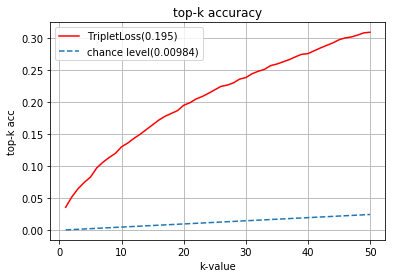

In [74]:
x = list(range(1,51))
chancelv=np.array(x)/len(test_pairs)

topk_vals = calc_topk_vals(x,ans_ids,topN_id_list)
plt.plot(x,topk_vals,c='r',label='TripletLoss({})'.format(round(topk_vals[19],3)))
# plt.plot(x,topk_vals,c='r',marker='o',label='improvedTripletLoss({})'.format(round(topk_vals[4],3)))
plt.plot(x,chancelv,linestyle='dashed',label='chance level(0.00984)')

# graph settings
plt.legend(loc='best')#,bbox_to_anchor=(1, 0.2))
plt.grid('True')
plt.title("top-k accuracy")
plt.xlabel("k-value")
plt.ylabel("top-k acc")
plt.show()

# 結果と考察

- vec_lengthは結果に対してかなり影響がある

Top20 accuracy

| Dimension | Single | Dual(Triplet Loss) | Dual(improved Triplet Loss) |
|:-:|:-:|:-:|:-:|
|100|  0.141  | - | -|
|200|-  |0.175  | - |
|300|-  | 0.126 | 0.201 |
|512|0.2  |0.156  |0.108  |

alpha=0.5にしたら0.157に変化した
原因はhistgram要確認
